## (What is overfitting and is it as bad as they say?: Video 61)

**Refer to Machine Learning Specialization by Andrew Ng for more details**

<img title="" src="./Images/1.png" alt="" width="495">

## Separate data to train-test split using numpy (Cross-validation -- manual separation: Video 64)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
iris = sns.load_dataset('iris')
# convert pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()
# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species == 'setosa'] = 0 # no need
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

separate data into training and test set

In [3]:
# how many training examples
prop_training = 0.8
n_training = int(len(labels) * prop_training) # 80% * number of rows

# initialize a boolean vector to select data and labels
# to check data inserted to train. True means inserted to train
train_test_bool = np.zeros(len(labels), dtype=bool)

# randomly selecting rows to be used in training and testing
# generates random array of numbers length(80%*number of rows)
items_for_train = np.random.choice(range(len(labels)), n_training, replace=False)
train_test_bool[items_for_train] = True
train_test_bool

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False,  True, False, False, False,
       False, False,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

Boolean indexing is performed here, the boolean indexing operation returns a new array that contains a subset of elements from the original array, where only the elements with corresponding True values in the boolean array are included.

arr1 = np.array([1, 2, 3, 4, 5])

bool1 = np.array([True, False, True, False, True])

result = arr1[bool1]

print(result)  // output: [1 3 5]

In [4]:
# checking for balanced number of data i.e same number of 3 flowers
print(f'full data avg: {torch.mean(labels.float())}') # 1 means balanced dataset
print(f'training data avg: { torch.mean(labels[train_test_bool].float()) }')
print(f'test data avg: { torch.mean(labels[~train_test_bool].float()) }')

full data avg: 1.0
training data avg: 1.0499999523162842
test data avg: 0.800000011920929


In [5]:
# creating model architecture
ann_iris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3)
)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)

In [6]:
print(data.shape, data[train_test_bool].shape, data[~train_test_bool].shape)

torch.Size([150, 4]) torch.Size([120, 4]) torch.Size([30, 4])


In [7]:
num_epochs = 1000
losses = torch.zeros(num_epochs)
ongoing_acc = []

for epochi in range(num_epochs):
    y_hat = ann_iris(data[train_test_bool,:]) # forward prop
    ongoing_acc.append(100 * torch.mean(
        (torch.argmax(y_hat, axis=1) == labels[train_test_bool]).float()
    ))
    loss = loss_func(y_hat, labels[train_test_bool]) # loss func
    losses[epochi] = loss
    
    optimizer.zero_grad() # back prop
    loss.backward()
    optimizer.step()

In [8]:
# using training data
preds = ann_iris(data[train_test_bool,:])
train_acc = 100*torch.mean( (torch.argmax(preds,axis=1) == labels[train_test_bool]).float() )

# using test data
preds = ann_iris(data[~train_test_bool,:])
test_acc = 100*torch.mean( (torch.argmax(preds,axis=1) == labels[~train_test_bool]).float() )
train_acc, test_acc

(tensor(97.5000), tensor(100.))

## Separate data to train-test split using sklearn (Cross-validation -- scikitlearn: Video 65)

In [9]:
def create_iris_data():
    # loading data
    iris = sns.load_dataset('iris')
    # convert pandas dataframe to tensor
    data = torch.tensor(iris[iris.columns[0:4]].values).float()
    # transform species to number
    labels = torch.zeros(len(data), dtype=torch.long)
    # labels[iris.species == 'setosa'] = 0 # no need
    labels[iris.species == 'versicolor'] = 1
    labels[iris.species == 'virginica'] = 2
    return data, labels


def create_model():
    ann_iris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)
    return ann_iris, loss_func, optimizer


num_epochs = 200
def train_model(train_size, data, labels, ann_iris):
    train_acc = []
    test_acc = []
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=train_size)
    
    for epochi in range(num_epochs):
        y_hat = ann_iris(x_train) # forward prop
        loss = loss_func(y_hat, y_train) # loss func
        optimizer.zero_grad() # back prop
        loss.backward()
        optimizer.step()
        train_acc.append( 100*torch.mean((torch.argmax(y_hat, axis=1) == y_train).float()).item() )
        
        pred_labels = torch.argmax(ann_iris(x_test), axis=1)
        test_acc.append( 100*torch.mean((pred_labels == y_test).float()).item() )
    return train_acc, test_acc

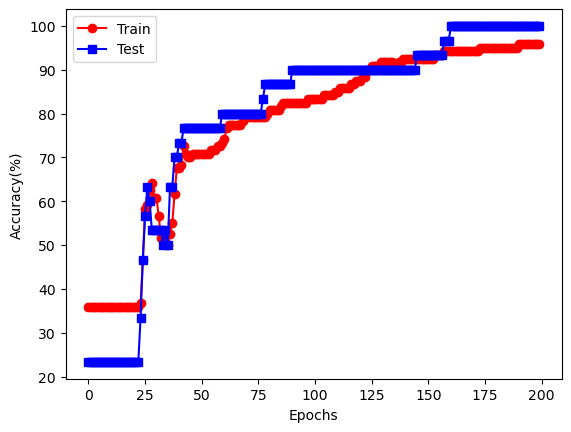

In [10]:
# testing the code once before performing the experiment
data, labels = create_iris_data()
ann_iris, loss_func, optimizer = create_model()
train_acc, test_acc = train_model(0.8, data, labels, ann_iris)

fig, ax = plt.subplots()
ax.plot(train_acc, 'ro-')
ax.plot(test_acc, 'bs-')
ax.set(xlabel='Epochs', ylabel='Accuracy(%)')
ax.legend(['Train', 'Test'])
plt.show()

In [11]:
train_set_sizes = np.linspace(0.2,0.95,10)
all_train_acc = np.zeros((len(train_set_sizes), num_epochs))
all_test_acc = np.zeros((len(train_set_sizes), num_epochs))

data, labels = create_iris_data()
for i in range(len(train_set_sizes)):
    ann_iris, loss_func, optimizer = create_model()
    train_acc, test_acc = train_model(train_set_sizes[i], data, labels, ann_iris)
    all_train_acc[i,:] = train_acc
    all_test_acc[i,:] = test_acc

Yellow means high accuracy, blue means low accuracy. The graphs do not really show anything meaningful

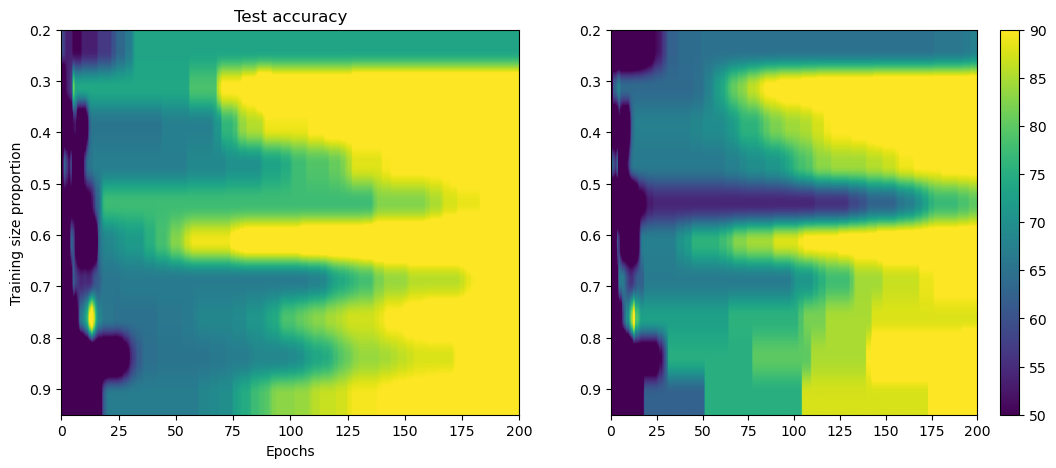

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
im1=ax1.imshow(all_train_acc, aspect='auto', 
           vmin=50, vmax=90, extent=[0,num_epochs,train_set_sizes[-1],train_set_sizes[0]])
ax1.set(xlabel='Epochs', ylabel='Training size proportion', title='Training accuracy')

im2=ax2.imshow(all_test_acc, aspect='auto', 
           vmin=50, vmax=90, extent=[0,num_epochs,train_set_sizes[-1],train_set_sizes[0]])
ax1.set(xlabel='Epochs', ylabel='Training size proportion', title='Test accuracy')
plt.colorbar(im2, ax=ax2)
plt.show()

## Separate data to train-test split/batch training using sklearn & pytorch (Cross-validation -- DataLoader: Video 66)

In [13]:
def create_iris_data():
    # loading data
    iris = sns.load_dataset('iris')
    # convert pandas dataframe to tensor
    data = torch.tensor(iris[iris.columns[0:4]].values).float()
    # transform species to number
    labels = torch.zeros(len(data), dtype=torch.long)
    # labels[iris.species == 'setosa'] = 0 # no need
    labels[iris.species == 'versicolor'] = 1
    labels[iris.species == 'virginica'] = 2
    return data, labels

def create_model():
    ann_iris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)
    return ann_iris, loss_func, optimizer

data, labels = create_iris_data()
ann_iris, loss_func, optimizer = create_model()

In [14]:
def split_data(data, labels):
    train_acc = []
    test_acc = []
    
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)
    # convert to pytorch datasets
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
    # convert to dataloader objects
    train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
    # batch size of test data is total no. of samples in dataset
    # all samples are included in 1 batch
    # test_data.tensors[0] selects the test_data, leaving out labels
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    return train_loader, test_loader

train_loader, test_loader = split_data(data, labels)
    
for x, y in train_loader:
    print(x, y)
    print(' ')

tensor([[4.4000, 3.2000, 1.3000, 0.2000],
        [5.1000, 3.8000, 1.9000, 0.4000],
        [6.7000, 2.5000, 5.8000, 1.8000],
        [5.5000, 2.3000, 4.0000, 1.3000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [5.0000, 3.5000, 1.6000, 0.6000],
        [5.7000, 2.6000, 3.5000, 1.0000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [6.1000, 2.8000, 4.7000, 1.2000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [6.0000, 2.2000, 5.0000, 1.5000],
        [6.1000, 2.8000, 4.0000, 1.3000]]) tensor([0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1])
 
tensor([[5.1000, 3.4000, 1.5000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.4000, 3.0000, 4.5000, 1.5000],
        [6.7000, 3.0000, 5.2000, 2.3000],
        [4.4000, 2.9000, 1.4000, 0.2000],
        [7.7000, 3.8000, 6.7000, 2.2000],
        [5.0000, 2.3000, 3.3000, 1.0000],
        [6.3000, 3.3000, 4.7000, 1.6000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [4.6000, 3.2000, 1.4000, 0.2000],
        [4.8000, 3.1000, 1.6

In [15]:
num_epochs = 500
def train_model(train_loader, test_loader, ann_iris, loss_func, optimizer):
    train_acc = []
    test_acc = []
    
    for epochi in range(num_epochs):
        batch_acc = []
        for x, y in train_loader:
            # forward prop and loss func
            y_hat = ann_iris(x)
            loss = loss_func(y_hat, y)
            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append( 100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item() )
        
        train_acc.append(np.mean(batch_acc))
        
        for x, y in test_loader:
            pred_labels = torch.argmax(ann_iris(x), axis=1)
            test_acc.append( 100*torch.mean((pred_labels == y).float()).item() )
    return train_acc, test_acc

train_acc, test_acc = train_model(train_loader, test_loader, ann_iris, loss_func, optimizer)

batch training performed better than training performed using only sklearn on the previous section

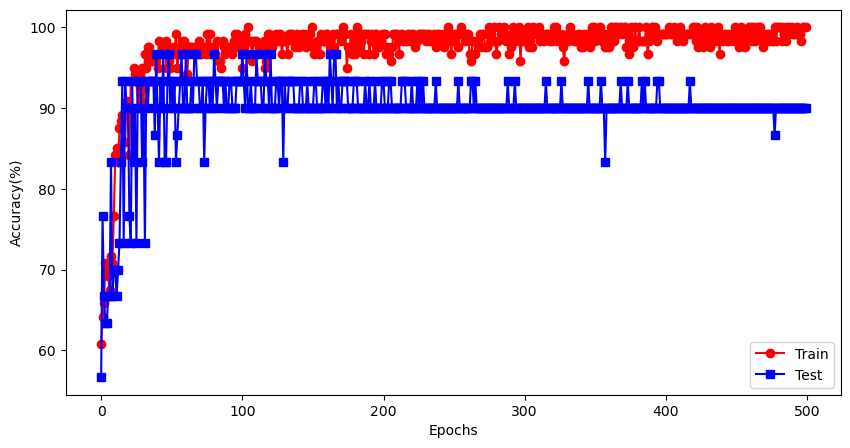

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_acc, 'ro-')
ax.plot(test_acc, 'bs-')
ax.set(xlabel='Epochs', ylabel='Accuracy(%)')
ax.legend(['Train', 'Test'])
plt.show()

## Separate data to train-devtest-test split using sklearn (Splitting data into train, devset, test: Video 67)
Previous sections explored into splitting to train and test set. In this section, splitting to train, devset and test sets are explored

In [17]:
# create fake data
fake_data = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fake_labels = np.arange(10)>4
print(fake_data), print(' ')
print(fake_labels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


**Using sklearn train test split**

Cannot do 0.1 as train_size on the second train_test_split call because the dataset has total 10 rows, train size takes 8 rows (80%), test_temp has 2 rows, and 0.1% of 2 rows, is not possible

In [18]:
partitions = [0.8,0.1,0.1]
train_data, test_temp_data, train_labels, test_temp_labels = train_test_split(fake_data, fake_labels, 
                                                                              train_size=partitions[0])

split = partitions[1] /np.sum(partitions[1:]) # 0.5
devset_data, test_data, devset_labels, test_labels = train_test_split(test_temp_data, test_temp_labels, 
                                                                     train_size=split)
print(train_data.shape, devset_data.shape, test_data.shape)

(8, 4) (1, 4) (1, 4)


## Separate data using sklearn & train model on regression (Cross-validation on regression: Video 68)
building a model that can predict the value of y based on the value of x

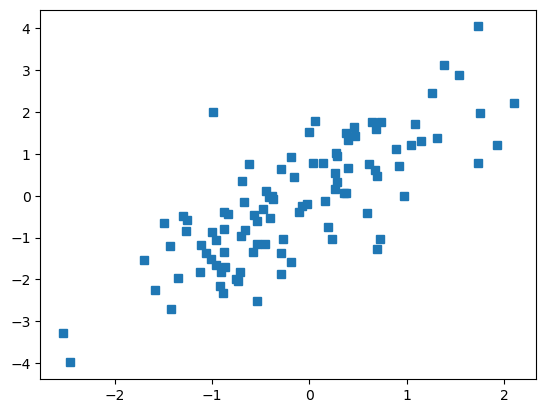

In [19]:
# generating data
N = 100
x = torch.randn(N,1)
y = x + torch.randn(N,1)

fig, ax = plt.subplots()
ax.plot(x,y,'s')
plt.show()

In [20]:
ann_reg = nn.Sequential(
    nn.Linear(1,1),
    nn.ReLU(),
    nn.Linear(1,1)
)

learning_rate = 0.05
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(ann_reg.parameters(), lr=learning_rate)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape

(torch.Size([80, 1]), torch.Size([20, 1]))

In [22]:
num_epochs = 500
for epochi in range(num_epochs):
    y_hat = ann_reg(x_train)
    loss = loss_func(y_hat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [23]:
y_preds = ann_reg(x_test)
test_loss = (y_preds - y_test).pow(2).mean()
print(f'final train loss {loss.detach():.2f}')
print(f'final test loss {test_loss.detach():.2f}')

final train loss 1.77
final test loss 3.57


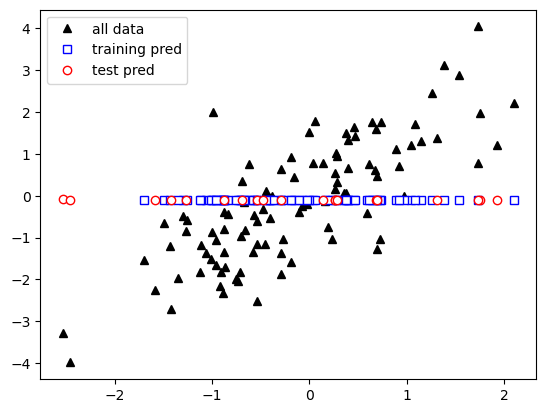

In [24]:
y_train_preds = ann_reg(x_train).detach().numpy()
fig, ax = plt.subplots()
ax.plot(x,y,'k^', label='all data')
ax.plot(x_train, y_train_preds, 'bs', markerfacecolor='w', label='training pred')
ax.plot(x_test, y_preds.detach(), 'ro', markerfacecolor='w', label='test pred')
plt.legend()
plt.show()